In [1]:
using Multilane
using POMDPs
using POMDPToolbox
using MCTS
using Distributions # for Normal
using DataArrays
using DataFrames
using DataFramesMeta

#using Interact
using Interact
using Reactive
#using Records
using AutoViz
using AutomotiveDrivingModels
using JLD
#using Cairo
#using Reel
#using GenerativeModels

INFO: Recompiling stale cache file /home/zhong/.julia/lib/v0.6/Multilane.ji for module Multilane.

Use "function Base.broadcast(::typeof(*), ...)" instead.

Use "function Base.broadcast(::typeof(^), ...)" instead.

Use "function Base.broadcast(::typeof(*), ...)" instead.

Use "function Base.broadcast(::typeof(^), ...)" instead.

Use "function Base.broadcast(::typeof(*), ...)" instead.

Use "function Base.broadcast(::typeof(*), ...)" instead.

Use "function Base.broadcast(::typeof(^), ...)" instead.

Use "function Base.broadcast(::typeof(-), ...)" instead.


Automatically loading visualization components.


In [2]:
#Set up problem configuration
nb_lanes = 4
pp = PhysicalParam(nb_lanes,lane_length=100.) #2.=>col_length=8
_discount = 1
nb_cars=10

#rmodel = NoCrashRewardModel()
rmodel  = NoCrashRewardModel(100.,0,2.5,4,100.,1,2500,3000)

#be = standard_uniform()
#dmodel = NoCrashIDMMOBILModel(nb_cars, pp, behaviors = be)
dmodel = NoCrashIDMMOBILModel(nb_cars, pp)

mdp = NoCrashMDP{NoCrashRewardModel}(dmodel, rmodel, _discount)

rng = MersenneTwister(5);

In [3]:
rmodel_after  = NoCrashRewardModel(100.,10.,2.5,4,0,1,2500,3000)

mdp_after = NoCrashMDP{NoCrashRewardModel}(dmodel, rmodel_after, _discount);

In [4]:
solver = DPWSolver(depth=30,
                    exploration_constant=10.0,
                    n_iterations=2000);

In [5]:
planner = solve(solver, mdp);

In [6]:
planner_after = solve(solver, mdp_after);

In [7]:
is = relaxed_initial_state(mdp);

simulate done


In [8]:
is.x = 0;
is.t = 0;
steps = 200;
sim = relaxed_initial_state_cz(mdp,is,planner,steps);


  [X] transition(::MLMDP, ::MLState, ::Void)
  [X] reward(::MLMDP, ::MLState, ::Void, ::MLState)

    
OR implement the following methods from the generative interface:

  [X] generate_s(::MLMDP, ::MLState, ::Void, ::AbstractRNG)
  [X] reward(::MLMDP, ::MLState, ::Void, ::MLState)

                     
([✔] = already implemented correctly; [X] = missing)


In [9]:
is.x = 0;
is.t = 0;
steps = 200;
sim_after = relaxed_initial_state_cz(mdp_after,is,planner_after,steps);

In [10]:
function get_sim_t_state(t::Int)
   s = sim.state_hist[t]
   a = sim.action_hist[t]
   sp = sim.state_hist[t+1]
   idx = Nullable{Int}()
end

get_sim_t_state (generic function with 1 method)

In [11]:
get_sim_t_state(70)
pp = mdp.dmodel.phys_param
roadway = gen_straight_roadway(pp.nb_lanes,
                               pp.lane_length,
                               lane_width=pp.w_lane)




cidol = CarIDOverlay()
cvol = CarVelOverlay()

idx = Nullable{Int}()

framerate = 6
ticks = fps(framerate)
timestamps = map(_-> time(),ticks)

1.519938478877524e9

In [12]:
function drawsim(timet)
    t = round(Int,rem(round(timet*framerate),steps-1)+1)
    s = sim.state_hist[t]
    a = sim.action_hist[t]
    sp = sim.state_hist[t+1]
    hbol = HardBrakeOverlay(pp, braking_ids(mdp, s, sp))
    iol = InfoOverlay(pp, idx,
                  s.cars[1].vel,
                  max_braking(mdp, s, sp),
                  is_crash(mdp, s, sp))
    scene = Scene()
    egox = s.x
    for cs in s.cars
        push!(scene, Vehicle(VehicleState(VecSE2(cs.x, (cs.y-1.0)*pp.w_lane, 0.0), roadway, cs.vel, egox),
                                #VehicleDef(cs.id, AgentClass.CAR, pp.l_car, pp.w_car)))
                                VehicleDef(AgentClass.CAR, pp.l_car, pp.w_car),cs.id))
    end
    
    render(scene, roadway,[RampStatsOverlay(1)], cam=FitToContentCamera(),car_colors=carcolors,canvas_height=220)
end

drawsim (generic function with 1 method)

In [13]:
function drawsim_after(timet)
    t = round(Int,rem(round(timet*framerate),steps-1)+1)
    s = sim_after.state_hist[t]
    a = sim_after.action_hist[t]
    sp = sim_after.state_hist[t+1]
    hbol = HardBrakeOverlay(pp, braking_ids(mdp, s, sp))
    iol = InfoOverlay(pp, idx,
                  s.cars[1].vel,
                  max_braking(mdp_after, s, sp),
                  is_crash(mdp_after, s, sp))
    scene = Scene()
    egox = s.x
    for cs in s.cars
        push!(scene, Vehicle(VehicleState(VecSE2(cs.x, (cs.y-1.0)*pp.w_lane, 0.0), roadway, cs.vel, egox),
                                #VehicleDef(cs.id, AgentClass.CAR, pp.l_car, pp.w_car)))
                                VehicleDef(AgentClass.CAR, pp.l_car, pp.w_car),cs.id))
    end
    
    render(scene, roadway,[RampStatsOverlay(1)], cam=FitToContentCamera(),car_colors=carcolors,canvas_height=220)
end

drawsim_after (generic function with 1 method)

In [14]:
function get_round(timet)
   return (round(Int,rem(round(timet*framerate),steps))) 
end

get_round (generic function with 1 method)

In [15]:
map(get_round,timestamps)

78

In [16]:
carcolors = Dict{Int,Colorant}()
carcolors[1] = colorant"green"

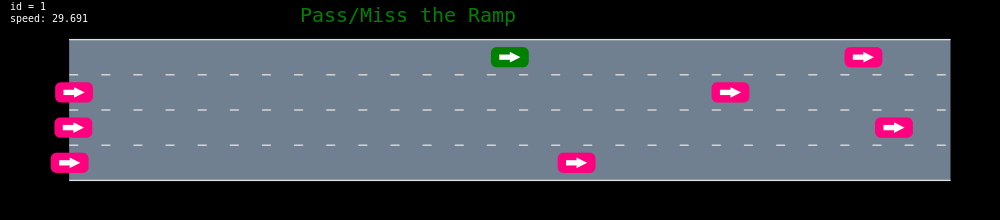

In [23]:
map(drawsim,timestamps)

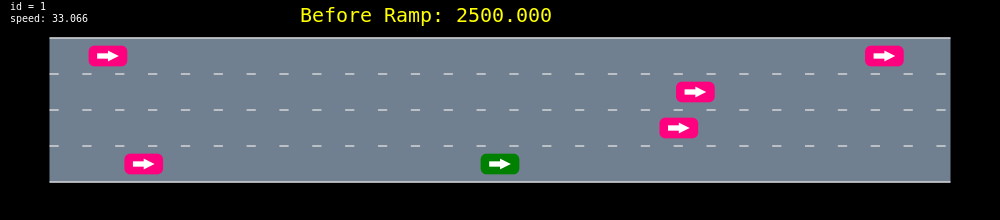

In [18]:
map(drawsim_after,timestamps)

In [19]:
#JLD.save("wait_to_change1.jld","sim",sim,"policy",planner)

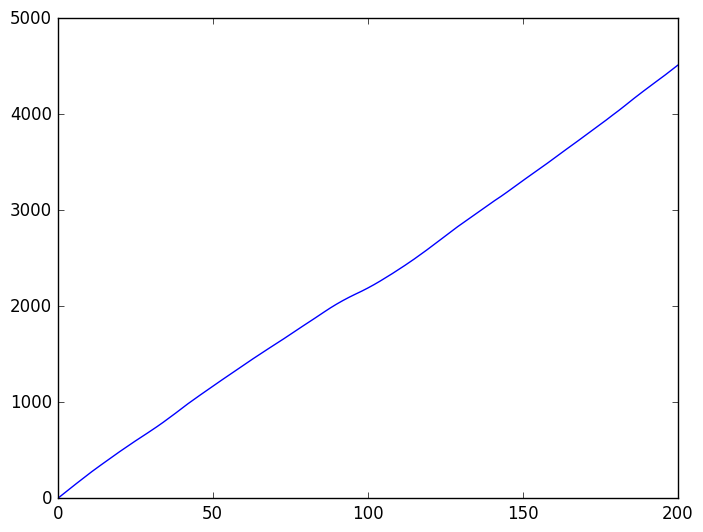

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f5a87442910>

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] max(::Array{Float64,1}, ::Array{Float64,1}) at ./deprecated.jl:57
 [3] poly_intersect(::Array{Array{Float64,2},1}, ::Array{Array{Float64,2},1}) at /home/zhong/.julia/v0.6/Multilane/src/crash.jl:80
 [4] #is_crash#5(::Bool, ::Function, ::Multilane.MLMDP{Multilane.MLState,Multilane.MLAction,Multilane.NoCrashIDMMOBILModel,Multilane.NoCrashRewardModel}, ::Multilane.MLState, ::Multilane.MLState, ::Bool) at /home/zhong/.julia/v0.6/Multilane/src/crash.jl:199
 [5] is_crash(::Multilane.MLMDP{Multilane.MLState,Multilane.MLAction,Multilane.NoCrashIDMMOBILModel,Multilane.NoCrashRewardModel}, ::Multilane.MLState, ::Multilane.MLState) at /home/zhong/.julia/v0.6/Multilane/src/crash.jl:120
 [6] drawsim(::Float64) at ./In[12]:7
 [7] (::Reactive.##33#34{#drawsim,Reactive.Signal{Cairo.CairoSurface{UInt32}},Tuple{Reactive.Signal{Float64}}})() at /home/zhong/.julia/v0.6/Reactive/src/operators.jl:39
 [8] foreach(::Reactive.#runaction, ::

In [20]:
using PyPlot
state = deepcopy(sim.state_hist);
ex = []
for i = 1:length(state)
    push!(ex,state[i].x)
end
plot(ex)

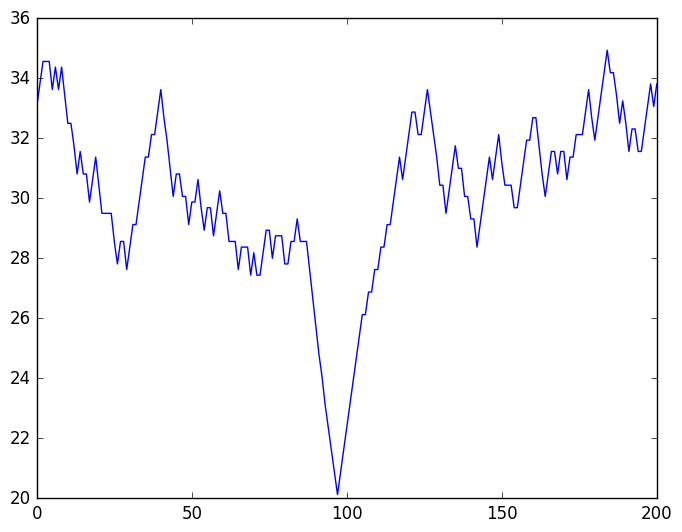

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f5a873704d0>

In [21]:
ego_vel = []
for i = 1:length(state)
    push!(ego_vel,state[i].cars[1].vel)
end
plot(ego_vel)

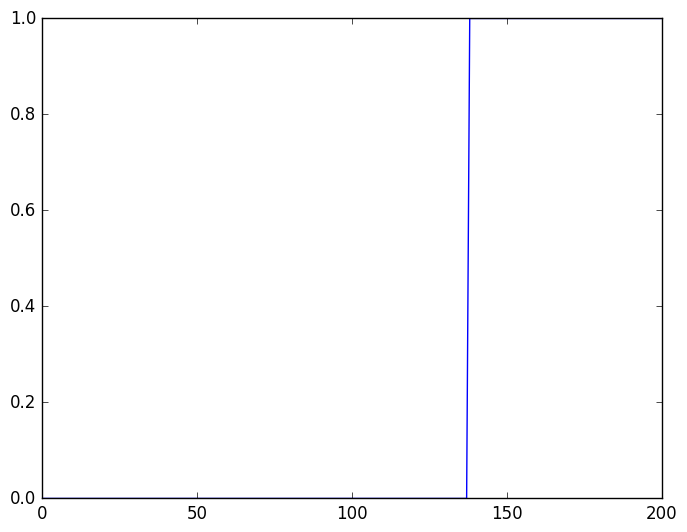

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f5a872b4b10>

In [22]:
tt = []
for i = 1:length(state)
    push!(tt,state[i].t)
end
plot(tt)